<h1>Analisis y modelado del IGAE</h1>

Utilizamos este docuemnto para hacer el analisis y modelado de la serie de tiempo del IGAE como auxiliar para la estimacion del credito al sector privado. Para el modelado utilizamos un enfoque de aprendizaje profundo tipo encoder-decoder, usando LSTM como encoder y MLP's como decoders, la arquitectura del modelo se encuentra en la carpeta arquitectura_modelos

Las series de tiempo se obtienen por medio de la API Banco de México con el propósito de que se puedan obtener y ajustar la estimación rápidamente ante la actualización de estas series.

In [1]:
from pathlib import Path
import os

os.chdir('C:/ABM/Analisis/Estimacion_Credito_Seq2seq')

# Buscar el primer directorio padre que contenga un archivo específico
def find_project_root(filename="requirements.txt"):
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / filename).exists():
            return parent
    raise FileNotFoundError(f"No se encontró {filename} en ningún directorio padre.")

# Establecer como root
os.chdir(find_project_root())
print("Nuevo directorio:", os.getcwd())

Nuevo directorio: C:\ABM\Analisis\Estimacion_Credito_Seq2seq


In [ ]:
# Importar librerias 

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from dotenv import load_dotenv

# Pytorch para redes neuroanles
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

# Importamos modulos propios
from api_caller.banxico import Banxico_SIE
from api_caller.inegi import INEGI_BIE
from procesamiento_datos import procesamiento_pron_pib
from arquitectura_modelos import MultivariateTimeSeriesDataset, Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster
from arquitectura_modelos.set_seed import set_seed


# Evitamos mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga variables de un archivo .env (para almacenar el token de la API de Banxico)
load_dotenv()

# Token
BANXICO_TOKEN = os.environ.get("Banxico_Token")
INEGI_TOKEN = os.environ.get("INEGI_Token") 

banxico_api = Banxico_SIE(BANXICO_TOKEN)
inegi_api = INEGI_BIE(INEGI_TOKEN)

# Lectura de series

In [4]:
# Descarga de series de banxico
fecha_inicio = '1994-03-01'

series_dict = {'SR17622':'PIB', 'SR17693':'IGAE'}

# Series
series_banxico = banxico_api.get_data(list(series_dict.keys()), fecha_inicio=fecha_inicio)

# Se ordenan las columnas, se verifica que los datos son numericos y se cambia el nombre de las series
series_banxico = series_banxico.sort_index(axis=1)
series_banxico = series_banxico.apply(pd.to_numeric, errors='coerce')
series_banxico = series_banxico.rename(columns=series_dict)

# Calculamos la media mensual de la serie en caso de tener series con mayor desagregacion
series_banxico = series_banxico.resample('MS').mean()

# Procesamiento

In [5]:
# Quitamos lo nan del inicio del dataframe
series = series_banxico[series_banxico.dropna().index.min():]

In [6]:
# Calculamos la variacion anual de las series de interes
series['IGAE_var'] = np.log(series['IGAE']).diff(12)*100
series['PIB_var'] = np.log(series['PIB']).diff(12)*100

In [7]:
print(series.tail())

                   PIB      IGAE  IGAE_var   PIB_var
2025-01-01         NaN  104.1302  0.181957       NaN
2025-02-01         NaN  105.2286  0.587590       NaN
2025-03-01  25444862.6  105.0180 -0.179617  0.567518
2025-04-01         NaN  105.4677  1.175390       NaN
2025-05-01         NaN  105.4816  0.441238       NaN


# Preparacion para entrenamiento

In [8]:
# Separamos las series objetivo y exógenas
series_objetivo = ['IGAE_var']
series_exogenas = ['PIB_var']
series_input = series_objetivo + series_exogenas

In [9]:
# Dataframe con las series de interes para introducirlas al modelo
df = series.copy().loc[series[series_exogenas].dropna().index, series_input]
df = df[df.dropna().index.min():]

# Definimos el periodo de entrenamiento y validacion
rezago_anos = 3

last_date = df[series_objetivo].dropna().index.max()
train_date = last_date + relativedelta(months=-12*rezago_anos)
validation_date = last_date + relativedelta(months=-12*(rezago_anos-1)//2)

# Separamos los datos de entrenamiento y validacion para el modelo de Seq2seq
df_train = df.loc[:train_date, :]
df_val = df.loc[:validation_date, :]
df_test = df.loc[:last_date, :]

print(f'Datos de entrenamiento desde {df.index.min().strftime('%Y-%m')}')
print(f"Datos de entrenamiento hasta el: {train_date.strftime('%Y-%m')}")
print(f"Datos de validacion hasta el: {validation_date.strftime('%Y-%m')}")
print(f"Datos de prueba hasta el: {last_date.strftime('%Y-%m')}")

Datos de entrenamiento desde 1995-06
Datos de entrenamiento hasta el: 2022-03
Datos de validacion hasta el: 2024-03
Datos de prueba hasta el: 2025-03


# Parametros

In [10]:
# Parametros de historia, horizonte de pronostico y batch size
hist_len = 4*4
horizon = 4*2
batch_size = 10

# Parametro para agregar un lag sobre la propia variable objetivo con intencion de capturar mejor la tendencia y estrutura de largo plazo
lag = hist_len

# Definimos variables de cambio de tendencia a partir de fecha designada (shock)
shock_dict = None

# Auxiliares para calculo de variables de entrada
len_shock_dict = len(shock_dict) if shock_dict is not None else 0
len_lag = 1 if lag>0 else 0

# Parametros de variables de entrada y salida
input_size = len(series_exogenas) + 5 + len_shock_dict + len_lag # Exogenas + objetivo + shocks + time features + lag
output_size = 1

# Parametros de tamaño de estado oculto y capas para el encoder LSTM
hidden_size = 128
num_layers = 2

# Parametros para capas MLP y contextos
global_mlp_layers = 300
ca_size = hidden_size
ct_size = hidden_size // 2
local_mlp_layers = 300

# Parametros de embedding para identificacion de series
num_embeddings = len(series_objetivo)
embedding_dim = 10*num_embeddings

# Parametro auxiliar para entrenamiento (ayuda a capturar estructura en periodos mas cortos durante el entrenamiento)
min_hist_len = 2

# Variable de cuantiles
quantiles = [0.05, 0.5, 0.95]

# Parámetros de optimización
learning_rate = 1e-3


# Fijamos una semilla para repoducir resultados
set_seed()

In [11]:

# Dataset de entrenamiento
train_dataset = MultivariateTimeSeriesDataset(
    df = df_train,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    lag = lag
)

# DataLoader en entrenamiento
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset de validación
val_dataset = MultivariateTimeSeriesDataset(
    df = df_val,
    target_cols = series_objetivo,
    exog_cols = series_exogenas,
    hist_len = hist_len,
    horizon = horizon,
    shock_dict = shock_dict,
    mean = train_dataset.mean,
    std = train_dataset.std,
    lag = train_dataset.lag
)

# DataLoader en validación
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Verificacion del shape de val_dataloader
for x_hist, x_fut, y_hist, y_fut, series_idx in iter(train_dataloader):
    print('\nShapes of the training batch:')
    print(f'x_hist: {x_hist.shape}')
    print(f'x_fut: {x_fut.shape}')
    print(f'y_hist: {y_hist.shape}')
    print(f'y_fut: {y_fut.shape}')
    print(f'series_idx: {series_idx}')
    break
    


Shapes of the training batch:
x_hist: torch.Size([10, 16, 6])
x_fut: torch.Size([10, 8, 6])
y_hist: torch.Size([10, 16, 1])
y_fut: torch.Size([10, 8, 1])
series_idx: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Entrenamiento

In [13]:
# Modelo
model = Seq2seq_MultiHorizon_Quantile_Recurrent_Forecaster(
    hist_len = hist_len,
    horizon = horizon,
    input_size = input_size,
    output_size = output_size,
    hidden_size = hidden_size,
    num_layers = num_layers,
    global_mlp_layers = global_mlp_layers,
    ct_size = ct_size,
    ca_size = ca_size,
    local_mlp_layers = local_mlp_layers,
    num_embeddings = num_embeddings,
    embedding_dim = embedding_dim,
    min_hist_len = min_hist_len,
    quantiles = quantiles,
    learning_rate = learning_rate,)

model.target_cols = series_objetivo
model.exog_cols = series_exogenas
model.mean = train_dataset.mean
model.std = train_dataset.std
model.shock_dict = train_dataset.shock_dict
model.series_id_map = train_dataset.series_id_map
model.lag = train_dataset.lag


In [14]:
# Verificacion de que el modelo funciona
batch = next(iter(train_dataloader))

x_hist, x_fut, y_hist, y_fut, series_idx = batch
y_hat, _, _ = model.forward(x_hist, x_fut, y_hist, series_idx)

# Vemos si hay nan
print("Shape de y_hat:", y_hat.shape)
print("Hay NaN en y_hat:", torch.isnan(y_hat).any().item())

Shape de y_hat: torch.Size([10, 8, 1, 3])
Hay NaN en y_hat: False


In [15]:
# Entrenamiento
epochs = 50

trainer = pl.Trainer(max_epochs=epochs)
trainer.fit(model, train_dataloader, val_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | series_embedding | Embedding  | 10     | train
1 | encoder          | LSTM       | 207 K  | train
2 | global_mlp       | Sequential | 269 K  | train
3 | local_mlp        | Sequential | 63.6 K | train
--------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.163     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s, v_num=0, train_loss_step=0.00779, val_QL=0.0248, train_loss_epoch=0.00681]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s, v_num=0, train_loss_step=0.00779, val_QL=0.0248, train_loss_epoch=0.00681]


# Validacion

In [ ]:
# Predicciones
initial_pred_date = pd.to_datetime("2023-06-01")
#initial_pred_date = validation_date + relativedelta(months=1)  # Ajustamos la fecha de inicio de predicción
end_year_pred = datetime(initial_pred_date.year, 12, 1)
end_year_1_pred = datetime(initial_pred_date.year + 1, 12, 1)

target_col = series_objetivo[0]

predicciones = model.predict(
    df = df,
    target_col = target_col,
    initial_pred_date = initial_pred_date
)

# Reindexamos la serie y rellenamos con interpolacion para tener todo el horizonte de pronostico en caso de no tenerlo
rango_mensual = pd.date_range(start=predicciones.index.min(), end= predicciones.index.max(), freq='MS')
predicciones = predicciones.reindex(rango_mensual)

# Se aplica interpolación lineal para rellenar los meses
predicciones = predicciones.interpolate(method='linear')

# Concatenar los dataframes
df_combined = pd.concat([df[series_input], predicciones], axis=1)

# Acotar el DataFrame a las fechas de interés
df_combined = df_combined.loc[initial_pred_date + relativedelta(months=-12):(initial_pred_date + relativedelta(months=12*2))]

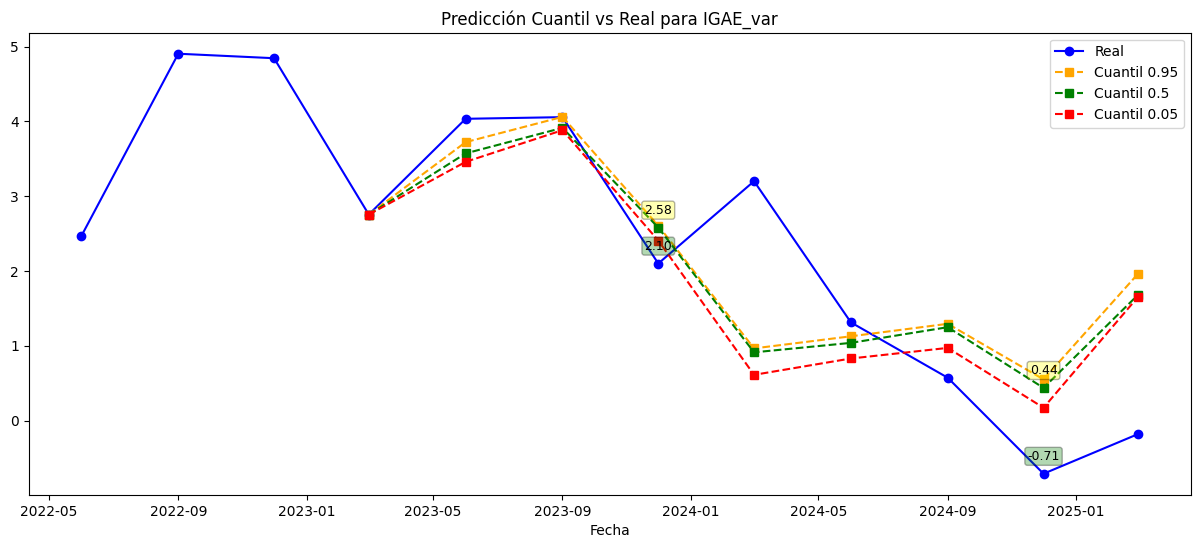

In [ ]:
# Iterar sobre cada variable objetivo para crear una gráfica
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la serie real
plt.plot(df_combined.index, df_combined[target_col], label='Real', marker='o', linestyle='-', color='blue')
#plt.plot(df_combined.index, df_combined['PIB_pron_var'], label='PIB', linestyle='-', color='gray')

if end_year_pred in df_combined.index:
    valor = df_combined.at[end_year_pred, target_col]
    ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))
    
if end_year_1_pred in df_combined.index:
    valor = df_combined.at[end_year_1_pred, target_col]
    ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.2', fc='green', alpha=0.3))


for quantile, color in zip(quantiles[::-1], ['orange', 'green', 'red']):
    col_name = f'{target_col}_{int(quantile*100)}'
    if col_name in df_combined.columns:
        plt.plot(df_combined.index, df_combined[col_name], label=f'Cuantil {quantile}', marker='s', linestyle='--', color=color)
        
        if col_name == f'{target_col}_50':
            if end_year_pred in df_combined.index:
                valor = df_combined.at[end_year_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
                
            if end_year_1_pred in df_combined.index:
                valor = df_combined.at[end_year_1_pred, col_name]
                ax1.annotate(f'{valor:.2f}', xy=(end_year_1_pred, valor), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))

plt.xlabel('Fecha')

plt.title(f'Predicción Cuantil vs Real para {target_col}')
plt.legend()
plt.show()



# Guardar Modelo

In [ ]:
# Guardar el modelo y sus atributos
guardar = False
if guardar:
    model_path = "modelos/IGAE_trim_seq2seq.pth"
    model.save_model(model_path)